<a href="https://colab.research.google.com/github/jacomyma/dtu-sts-material/blob/main/notebooks/colab/Semantic_map_Filter_and_explore_(interactive).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Semantic map - Filter and explore (interactive)

*DTU - Explore the Energy Islands controversy*

**Goal**:
- Filter the map using a condition (a **query**)
- Render the semantic map in Bokeh, which allows to zoom, pan, and read the text.

**How to use**:
- Edit settings if you want
- Then use "Runtime > Run all" or execute from the edited cell and below
- Wait for each cell to run
- ⚠️ Allow the script to access your Google Drive data when prompted to.
- **Edit the query** as you see fit
- Re-run that cell and the following ones to update the visualization


## Settings

In [ ]:
# SETTINGS (edit if necessary)
settings = {}
settings['interactive_plot_width']  = 1000 # In pixels
settings['interactive_plot_height'] =  600 # In pixels

## Code

(You don't have to understand what's going on here, but feel free to take a look)

In [ ]:
# Additional settings you shouldn't have to change
settings['statements_spreadsheet_drive_URL'] = 'https://docs.google.com/spreadsheets/d/1cSwVVXAB7kYRbGKEr6gc5IGs955dIfJNcCzyl_cywa8/edit?usp=drive_link'

### Install stuff
Note: already installed libraries will not be reinstalled, don't worry about re-running that.

In [ ]:
#!pip install pandas gspread==5.10.0 google-auth==2.22.0 google-auth-oauthlib==1.0.0 google-auth-httplib2==0.1.0 bokeh
!pip install pandas gspread google-auth google-auth-oauthlib google-auth-httplib2 bokeh

In [ ]:
# Import necessary libraries
import pandas as pd
import json
import matplotlib.pyplot as plt

from google.colab import auth
auth.authenticate_user()

import gspread
from google.auth import default
creds, _ = default()

gc = gspread.authorize(creds)

import bokeh
import bokeh.plotting as bp
from bokeh.io import output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, CategoricalColorMapper
from bokeh.transform import factor_cmap

### Load data from the corpus

In [ ]:
# Open the spreadsheet by its key or URL
spreadsheet_key = settings['statements_spreadsheet_drive_URL'].split('/d/')[1].split('/edit')[0]
sh = gc.open_by_key(spreadsheet_key)

# Select the worksheet
worksheet_name = 'dataset'
worksheet = sh.worksheet(worksheet_name)

In [ ]:
# Get all values from the worksheet as a list of lists
data = worksheet.get_all_values()

# Create a Pandas DataFrame from the list of lists
df = pd.DataFrame(data[1:], columns=data[0])

# Set 'Year' column to int
df['Year'] = df['Year'].replace('', pd.NA)
df['Year'] = pd.to_numeric(df['Year'], errors='coerce').astype(pd.Int64Dtype())

# Set 'X', 'Y' and 'Size' columns to float
df['X'] = pd.to_numeric(df['X'], errors='coerce')
df['Y'] = pd.to_numeric(df['Y'], errors='coerce')
df['Size'] = pd.to_numeric(df['Size'], errors='coerce')

# Display dataframe for monitoring purposes
#df
print('Data loaded.')

Data loaded.


### Other prep we need

In [ ]:
# This is the function we will use to visualize a matching condition
def visualize(condition, title='Proportion of filtered items'):
  # Make a copy of df
  df_copy = df.copy()

  # Mark each row of df_copy as filtered if the condition is fulfilled
  df_copy['filtered'] = condition

  # Plot a pie chart with counts and percentages
  filtered_counts = df_copy['filtered'].value_counts()

  def make_autopct(values):
      def my_autopct(pct):
          total = sum(values)
          val = int(round(pct*total/100.0))
          return '{p:.1f}%\n({v:d})'.format(p=pct,v=val)
      return my_autopct

  # Define the colors for True and False
  colors = ['#4deded' if label else '#EAEAEA' for label in filtered_counts.index]

  # Create a figure with a small size
  plt.figure(figsize=(3, 3))

  plt.pie(filtered_counts, autopct=make_autopct(filtered_counts), colors=colors, startangle=90)
  plt.title(title)
  plt.show()

# Filtering condition (QUERY)

**Edit the condition (the query)**, then run this cell and those below to update them. Also give a title to your query for clarity.

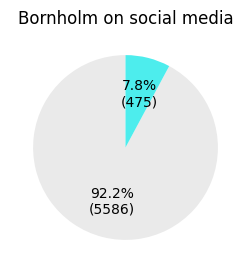

In [ ]:
# EDIT ME
condition = (
    (df['Statement'].str.contains('Bornholm', case=False, na=False))
  & (df['Source type'] == "Social media")
)

# EDIT ME (give an appropriate title to the query)
title = "Bornholm on social media"

# Check that it works
visualize(condition, title)

# Plot the semantic map

In [ ]:
# Make a copy of df
df_copy = df.copy()

# Mark each row of df_copy as filtered if the condition is fulfilled
df_copy['filtered'] = condition

# Set attribute to visualize
painted_attribute = 'filtered'

# Sort the DataFrame based on 'painted_attribute'
df_copy = df_copy.sort_values(by=[painted_attribute], ascending=True)

# Now extract the painted_data from the sorted DataFrame
painted_data = df_copy[painted_attribute].astype(str)
# Create a ColumnDataSource for Bokeh
source = ColumnDataSource(data=dict(
    x=df_copy['X'],
    y=df_copy['Y'],
    size=df_copy['Size'],
    actor=df_copy['Actor'],
    source=df_copy['Source name'],
    sourceType=df_copy['Source type'],
    year=df_copy['Year'],
    date=df_copy['Date of publication'],
    text=df_copy['Statement'],
    id=df_copy['id'],
    filtered=df_copy[painted_attribute],
    attribute_to_paint=painted_data,
))

# Get modalities and create a color mapper
modalities = painted_data.unique()
modalities.sort()
if len(modalities) == 1:
  palette = ['#303040']
else:
  palette = ['#EAEAEA', '#00bbbd']
color_mapper = CategoricalColorMapper(factors=list(modalities), palette=palette)

In [ ]:
# Output the plot to the notebook
output_notebook()

# Create the figure
p = bp.figure(width=1200, height=600,
            title="Actor statements",
            tools="pan,wheel_zoom,box_zoom,reset,hover", match_aspect=True)

# Add scatter plot with color mapping and hover tool
p.scatter('x', 'y', source=source, size='size',
        color={'field': 'attribute_to_paint', 'transform': color_mapper},
        legend_group='attribute_to_paint'
        )

# Customize the plot (optional)
p.legend.title = title

# HTML tooltip
hover = p.select(dict(type=HoverTool))
hover.tooltips = """
    <div style="width: 300px; word-wrap: break-word;">
        <div>@text</div>
        <div><em>&mdash;@actor, @source, @date. [@id]</em></div>
        <br>
    </div>
"""
hover.mode = 'mouse' # Enable HTML rendering

# Show the plot
show(p)